In [1]:
import numpy as np
import os
import warnings

np.random.seed(42)
warnings.filterwarnings(action="ignore", category=FutureWarning)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

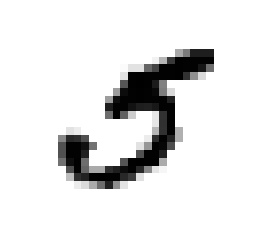

In [6]:
sample_5 = X[36000]
sample_5_image = np.reshape(sample_5, (28, 28))
plt.imshow(sample_5_image, cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()

In [7]:
y[36000]

5.0

In [8]:
# test and train sets alreaady split by sklearn
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle to make sure that when we do cross validation, each fold contains all the numbers
# np.random.permutation takes an int (treated as a range from 0~) or a list and shuffles it
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [9]:
# trying to just identify a single digit for now
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [10]:
from sklearn.linear_model import SGDClassifier

# 'stochastic' means 'random determined'
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([sample_5])

array([ True])

# Performance Measures

In [12]:
# cross validation is one way to measure the accuracy of a model
# K-fold CV does the following
# 1. splits the training set into a given number (K) of folds
# 2. trains a model on the training fold data, and makes predictions on the fold test data
# 3. (?)evaluates those predictions on each fold using a model trained on the other folds
from sklearn.model_selection import cross_val_score

# the 'accuracy' scoring is the ratio of correct predictions
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
# Because only 10% of the images are 5s, we can get 90% accuracy just by guessing 'not 5' every time.
# Accuracy scoring is generally not the preferred way to measure classifier performance.
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [30]:
# Custom implementation of cross validation with accuracy scoring
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X=X_train_folds, y=y_train_folds)
    y_pred = clone_clf.predict(X=X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495
